# Required Imports 

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from random import sample

warnings.filterwarnings('ignore')
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [3]:
location='../input/creditcardfraud/creditcard.csv'

## Reading the transactions data into the data frame 

In [4]:
df=pd.read_csv(location)

### Dataset is classfied as fradulent and Non fradulent (1 - Fradulent ; 0 - Non Fradulent)

In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Visualizing the catogeries

In [6]:
# we can see that the fradulent samples are negligible when compared to the non fradulent indicating that Class Imbalance exists in the dataset

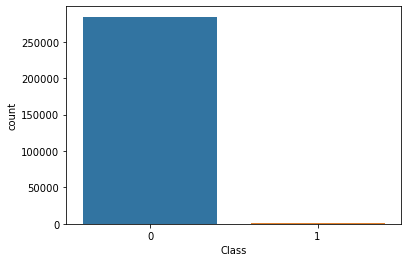

In [7]:
 sns.countplot(x='Class',data=df)

## Segregating Numerical and Catogerical Columns

In [8]:

def getCatogericalandNumericalColumns(columns):
    numericalcolumns=[]
    catogericalcolumns=[]
    for column in columns:
        if(len(df[column].value_counts())<=7):
            catogericalcolumns.append(column)
        else:
            numericalcolumns.append(column)
    return numericalcolumns,catogericalcolumns

In [9]:
num,cat=getCatogericalandNumericalColumns(df.columns)

Removing Outliers from using IQR method

In [10]:
Q1 = df[num].quantile(0.25)
Q3 = df[num].quantile(0.75)
IQR = Q3 - Q1

In [11]:
def updateNumLowHigh(col):
    low  = Q1[col] - 1.5 * IQR[col]
    high = Q3[col] + 1.5 * IQR[col]
    df.loc[df[col]<low,[col]]=low
    df.loc[df[col]>high,[col]]=high

In [12]:
for col in num:
    updateNumLowHigh(col)

## Declaring Standard Scalar to Normalize the numerical columns

In [13]:
preprocess = make_column_transformer(
    (StandardScaler(), num)
)

## Extracting Validation set from the dataset 

In [14]:
validation_remains=284807-280000


## Chosen Size of Validation Set now will pick random examples of validation size and seperate them from the Original Dataset 

In [16]:
validation_remains

4807

In [24]:
validation_index=sample(list(df[df.Class==0].index),validation_remains)

In [25]:
validation_set=df.iloc[validation_index]

In [27]:
df=df.drop(validation_index)

## Applying the Standard Scalar to Normalize the data 

In [28]:
x=preprocess.fit_transform(df.drop(['Class'],axis=1))

## Replacing all the null values with Zero

In [29]:
df.Class=df.Class.fillna(0)

### splitting the data into training and test sets 

In [30]:

X_train, X_test, y_train, y_test = train_test_split(x,df.Class, test_size=0.3, stratify=df.Class)

In [59]:
# Enabling Eager Execution

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

In [60]:
# Reshaping the Example Size

In [34]:
X_train = X_train.reshape((len(X_train),30))
X_test  = X_test.reshape((len(X_test),30))

# Implementation of Conditional Variational Auto Encoder for Data Augmentation of Samples of Minority Class

## Hyperparameters
Assign the type of optimizer, batch size, latent-space representation size, and number of epochs

In [37]:
m   = 1000 # batch size
n_z = 2   # latent space size

encoder_dim1 = 15 # dim of encoder hidden layer
decoder_dim  = 15 # dim of decoder hidden layer

decoder_out_dim = 30 # dim of decoder output layer

activ = 'relu'
optim = Adam(lr=0.001)

n_x = X_train.shape[1]
n_y = 1


n_epoch = 1500

## The encoder
- We'll be using the Keras functional API rather than the sequential because of the slightly more complex structure of the CVAE. 
- First we'll explicitly define __input__ layers for __X__ and __y__. 

- Keras needs to know their shapes at the input layer, but can infer them later on.

In [38]:
X     = Input(shape=(n_x,))
label = Input(shape=(n_y,))

## Next we'll concatenate the X and y vectors. 

### we  maintain X and y vectors as  separate entities so that we can properly calculate our reconstruction error (we aren't asking the autoencoder to reassemble y in addition to X).

In [39]:
inputs = concat([X, label])

### Once we've defined our inputs and merged them within the context of the graph, we'll pass them to a dense layer consisting of the previuosly specified number of neurons (15) and activation function (ReLU). That layer is then connected to layers that produce our mean ($\mu$) and standard deviation ($\log(\sigma)$) for the variational sampling that occurs later.

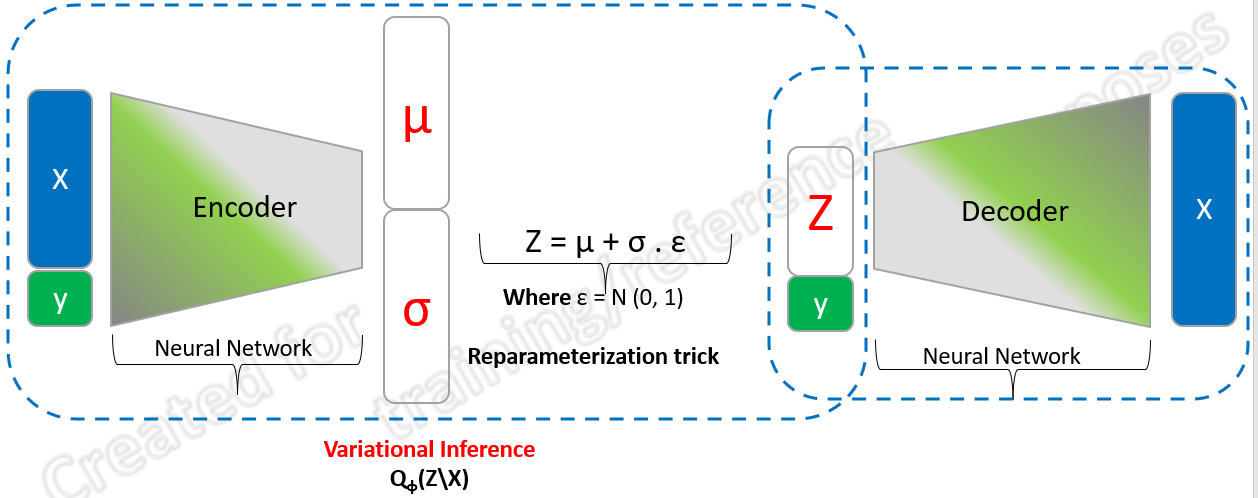

In [40]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)

mu      = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

### Next we define a function that adds random normal noise to our sampling process, and call it with a Lamda layer.

In [41]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# Sampling latent space
z = Lambda(sample_z, output_shape =(n_z,))([mu, l_sigma])

## The latent space

### Now that we've built our encoder and defined our sampling function, our latent space (z) is easy to define.
### First, using our sample_z function, we generate a vector of length n_z (in this case 2). If this were a normal VAE we could stop here and move on to the decoder, but instead we are going to concatenate our latent z respresentation with the same sparse y vector

In [42]:
# merge latent space with label
zc = concat([z, label])

## Decoder
### The encoder has hopefully taken the information contained in 784 pixels (plus the class label), and created some vector z. The decoding process is the reconstruction from z to X_hat. Unlike a normal undercomplete autoencoder, we won't stick to a rigid symmetrical funnel-type architecture here. Instead I'll define two dense layers of 15 and 30 neurons that have ReLU and sigmoidal activation functions, respectively.

In [43]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out    = Dense(decoder_out_dim, activation='sigmoid')

h_p     = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [44]:
cvae    = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h  = decoder_hidden(d_in)
d_out   = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [45]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [46]:
def vae_loss(y_true, y_pred):
    
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    
    return recon + kl

def KL_loss(y_true, y_pred):
	return (0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

## Training

### We train the model as a whole, using the compile and fit methods for the cvae object. We'll use the optimizer that we defined previously, our custom vae_loss, and we'll also pass the KL_loss and recon_loss to the metrics argument so that they'll be tracked by batch.

### For the fit method we pass a list of inputs, validation data, the number of epochs, and a callback that stops the model early if validation loss hasn't improved in the past 5 epochs.

In [47]:
cvae.compile(optimizer=optim, 
             loss=vae_loss, 
             metrics = [KL_loss, recon_loss])

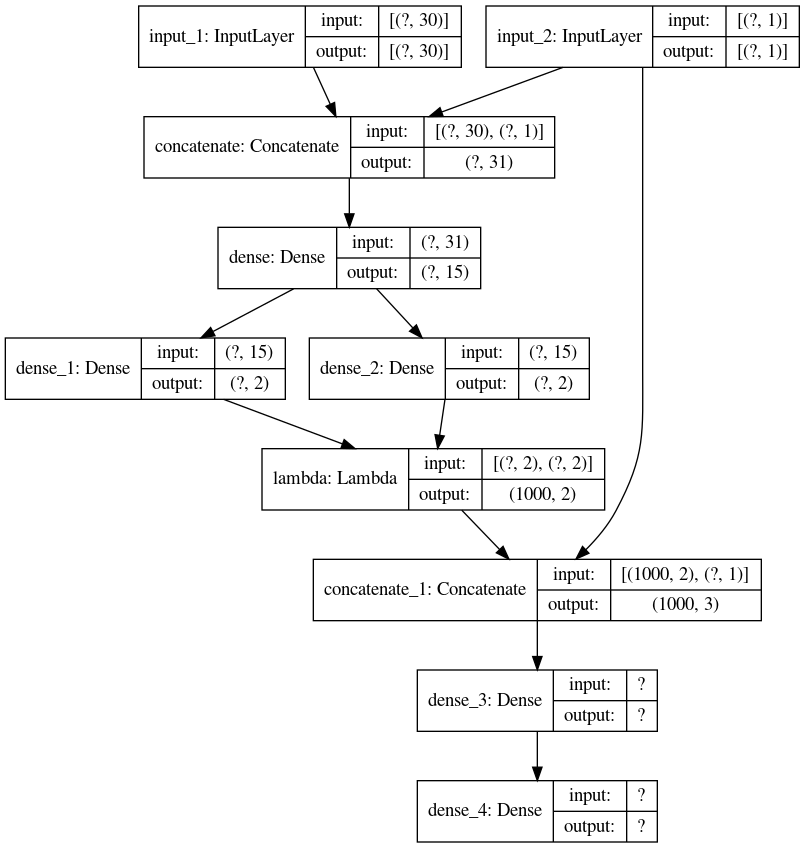

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(cvae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], 
                     X_train, 
                     verbose = 1, 
                     batch_size=m, 
                     epochs=1500,
                     validation_data = ([X_test, y_test], X_test),
                     callbacks = [EarlyStopping(patience = 5)])

Epoch 1/1500
196/196 [==============================] - 26s 134ms/step - loss: 0.0000e+00 - KL_loss: 0.0000e+00 - recon_loss: 23.5331 - val_loss: 0.0000e+00 - val_KL_loss: 0.0000e+00 - val_recon_loss: 23.5382
Epoch 2/1500
196/196 [==============================] - 26s 133ms/step - loss: 0.0000e+00 - KL_loss: 0.0000e+00 - recon_loss: 23.5129 - val_loss: 0.0000e+00 - val_KL_loss: 0.0000e+00 - val_recon_loss: 23.5418
Epoch 3/1500
196/196 [==============================] - 26s 135ms/step - loss: 0.0000e+00 - KL_loss: 0.0000e+00 - recon_loss: 23.5317 - val_loss: 0.0000e+00 - val_KL_loss: 0.0000e+00 - val_recon_loss: 23.5301
Epoch 4/1500
196/196 [==============================] - 27s 137ms/step - loss: 0.0000e+00 - KL_loss: 0.0000e+00 - recon_loss: 23.5519 - val_loss: 0.0000e+00 - val_KL_loss: 0.0000e+00 - val_recon_loss: 23.5164
Epoch 5/1500
196/196 [==============================] - 26s 134ms/step - loss: 0.0000e+00 - KL_loss: 0.0000e+00 - recon_loss: 23.5248 - val_loss: 0.0000e+00 - val_K

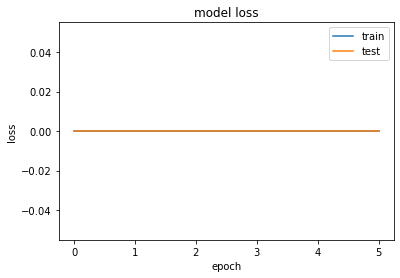

In [52]:
# plots - Loss
plt.plot(cvae_hist.history['loss'])
plt.plot(cvae_hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [53]:
n_y=1
n_z=2

In [54]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

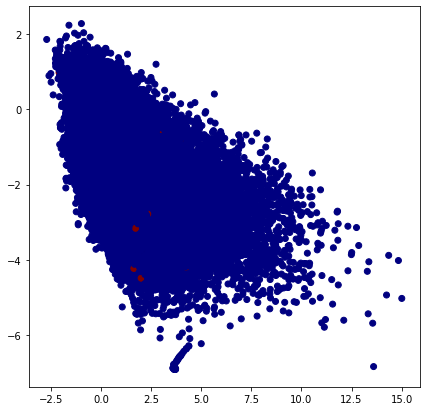

In [55]:
z_train = encoder.predict([X_train, y_train])

encodings= np.asarray(z_train)

encodings = encodings.reshape(X_train.shape[0], n_z)

plt.figure(figsize=(7, 7))

plt.scatter(encodings[:, 0], 
            encodings[:, 1], 
            c=y_train, 
            cmap=plt.cm.jet)

In [56]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z-1] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

In [57]:
sample_3 = construct_numvec(1)
print(sample_3)

[[0. 0. 1.]]


In [ ]:
fradulent_newsamples=[]

In [ ]:
# reading the transactions data into the data frame 
df=pd.read_csv(location)

In [ ]:
df.shape

In [ ]:
df[df.Class==0]

In [ ]:
import random

In [ ]:
index=random.sample(list(df[df.Class==0].index),2000)

In [ ]:
pos=len(index)

In [ ]:
pos

In [ ]:
neg=492

In [ ]:
req_fradulent_samples=pos-neg

In [ ]:
req_fradulent_samples

In [ ]:
fradulent_newsamples=[]

In [ ]:
del(df)

In [ ]:
vec = construct_numvec(1, z_)

In [ ]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z-1] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

In [ ]:
vec = construct_numvec(1, z_)

In [ ]:
decoder.predict(vec)

In [ ]:
dig = 1
sides = 40
max_z = 1.5

img_it = 0

for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        fradulent_newsamples.append(decoded)
        print(decoded)
        

In [ ]:
len(fradulent_newsamples)

In [51]:
df2=pd.DataFrame(np.array(fradulent_newsamples).flatten().reshape(6216,30))

NameError: name 'fradulent_newsamples' is not defined

In [ ]:
df2['Class']=np.ones(6216)

In [ ]:
df=df.iloc[index]

In [ ]:
df2.shape

In [ ]:
df.shape

In [ ]:
df.columns=df2.columns

In [ ]:
df=df.append(df2)

In [ ]:
del(df2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class',axis=1),df.Class, test_size=0.33)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
result=clf.predict(X_test)

In [ ]:
res=np.array(result==y_test)*1

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,clf.predict(X_test))